In [1]:
import os
import datetime

import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
from matplotlib import dates as mdates
from scipy.integrate import solve_ivp

from coropy.compartmental_models import SEIRDModel
import plotting

In [2]:
plotting.configure()
b = plotting.default_colors('blue')
o = plotting.default_colors('orange')
g = plotting.default_colors('green')
r = plotting.default_colors('red')

In [3]:
# all data
DATA_DIR = 'data'
FILE_NAMES = ['initial_timeseries_SEIRD.csv',
              '2nd_wave_timeseries_SEIRD.csv']
FILE_PATHS = [os.path.join(os.pardir, DATA_DIR, FILE_NAMES[0]),
              os.path.join(os.pardir, DATA_DIR, FILE_NAMES[1])]
df_1 = pd.read_csv(FILE_PATHS[0])
df_2 = pd.read_csv(FILE_PATHS[1])

# derived data
cum_positives_1 = np.cumsum(df_1.confirmed_positives.values)
cum_recovered_1 = df_1.estimate_recovered.values
cum_deceased_1 = np.cumsum(df_1.confirmed_deceased.values)
active_1 = cum_positives_1 - cum_recovered_1 - cum_deceased_1

cum_positives_2 = np.cumsum(df_2.confirmed_positives.values) + cum_positives_1[-1]
cum_recovered_2 = df_2.estimate_recovered.values
cum_deceased_2 = np.cumsum(df_2.confirmed_deceased.values) + cum_deceased_1[-1]
active_2 = cum_positives_2 - cum_recovered_2 - cum_deceased_2

# initial conditions
S0_1 = cum_positives_1[-1] + cum_deceased_1[-1]
E0_1 = 10
I0_1 = 1
R0_1 = 0
D0_1 = 0
IC_1 = [S0_1, E0_1, I0_1, R0_1, D0_1]

In [5]:
# transmission rate
beta = 0.5

# system of odes
def SEIRD_ode(t, y, delta, alpha, gamma, mu):
    S, E, I, R, D = y
    N = S + E + I + R + D
    return [
        -beta*S*I/N - delta*S*E, 
        beta*S*I/N - alpha*E + delta*S*E, 
        alpha*E - gamma*I - mu*I, 
        gamma*I,
        mu*I,
    ]

model = SEIRDModel(ode_system=SEIRD_ode)
params, loss = model.fit(cum_positives_1, cum_recovered_1, cum_deceased_1, IC_1, guess=[0.1, 0.1, 0.1, 0.1])
S_1, E_1, I_1, R_1, D_1 = model.simulate()

INFO:root:L-BFGS-B optimization started: 2020-10-12 10:50:38.881483
INFO:root:Elapsed time: 24.321s


In [19]:
IC_2 = [S0_1*5, E_1[-1], I_1[-1], R_1[-1], D_1[-1]]

In [20]:
sol = solve_ivp(
    fun=SEIRD_ode,
    t_span=(0, active_2.size),
    y0=IC_2,
    method='RK45',
    t_eval=np.linspace(0, 1, active_2.size),
    vectorized=True,
    args=params,
)

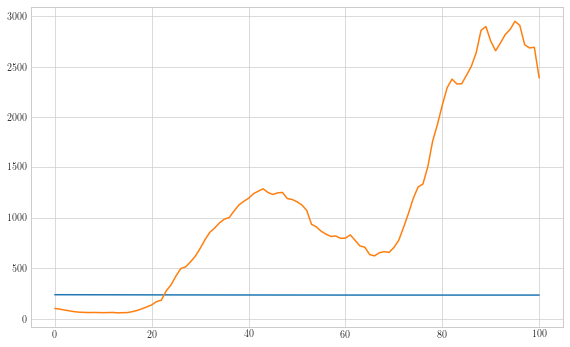

In [21]:
plt.plot(sol.y[2])
plt.plot(active_2)